In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle
import random

from torchvision.models import resnet18
from torchvision.models.resnet import ResNet18_Weights


In [2]:
torch.manual_seed(2004)
random.seed(2004)
np.random.seed(2004)

In [3]:
BATCH_SIZE = 512 # Assumed
LR = 0.025 # Same as paper
MOMENTUM = 0.9 # Same as paper
EPOCHS = 4
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PRINT_INTERVAL = 1000

MODEL_SAVE_DIR = "models"

In [4]:

transform = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=0), # Padding not mentioned in paper
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

if not os.path.exists("embeddings/active_learning_embeddings.pkl"):
    raise ValueError("Please run eval_sim_clr.py first to generate embeddings for active learning")
with open("embeddings/active_learning_embeddings.pkl", "rb") as f:
    active_learning_embeddings = pickle.load(f)

print("Embeddings shape:", len(active_learning_embeddings))

all_images = []
all_labels = []

for key, value_dict in active_learning_embeddings.items():
    all_images.append(value_dict["image"])
    all_labels.append(value_dict["label"])

train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Embeddings shape: 496


In [5]:
print(len(train_dl))
print(len(test_dl))

98
20


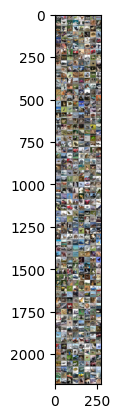

dog   truck frog  plane bird  deer  bird  ship  frog  bird  horse ship  ship  car   dog   frog  car   bird  deer  plane cat   ship  horse frog  cat   horse car   cat   horse bird  cat   bird  plane car   car   car   deer  dog   frog  truck cat   frog  car   ship  frog  dog   car   horse plane dog   deer  car   cat   frog  car   truck frog  frog  deer  bird  cat   truck horse dog   dog   plane ship  dog   ship  plane bird  plane ship  deer  bird  ship  truck horse bird  bird  car   dog   bird  frog  deer  cat   horse truck ship  cat   dog   ship  plane horse dog   deer  truck bird  deer  deer  deer  cat   car   ship  bird  horse frog  bird  car   plane cat   dog   deer  deer  car   dog   dog   cat   car   cat   plane cat   cat   horse plane car   ship  deer  ship  bird  bird  deer  cat   cat   car   dog   cat   cat   car   plane truck horse truck horse plane frog  horse dog   dog   plane dog   truck horse bird  horse horse cat   bird  horse ship  dog   frog  horse bird  ship  bird  bird

In [6]:
def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

data_iter = iter(train_dl)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))
print(" ".join(f"{classes[labels[j]]:5s}" for j in range(BATCH_SIZE)))

In [7]:
def create_resnet18_model():
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(512, 10) # Adapt final layer to CIFAR-10 classes
    return model

In [8]:
model = create_resnet18_model()
model = model.to(DEVICE)

In [9]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)

In [10]:
print(len(train_dl), len(test_dl))

98 20


In [11]:
num_train_batches = len(train_dl)

In [12]:
for epoch in range(EPOCHS):
    running_loss = 0.0
    total_examples = 0
    for i, data in enumerate(train_dl):
        inputs, labels = data
        optimiser.zero_grad()

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        output = model(inputs)

        loss = criterion(output, labels)

        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        total_examples += len(labels)

        if (i % PRINT_INTERVAL == (PRINT_INTERVAL - 1)) or (i == num_train_batches - 1):
            print(f"Epoch: {epoch + 1} |  Batch: {i + 1}/{num_train_batches} | Loss: {running_loss / total_examples}")

Epoch: 1 |  Batch: 98/98 | Loss: 0.0018559360516071318
Epoch: 2 |  Batch: 98/98 | Loss: 0.001072725157737732
Epoch: 3 |  Batch: 98/98 | Loss: 0.0008356838691234589
Epoch: 4 |  Batch: 98/98 | Loss: 0.0007013811630010605


In [13]:
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
model_path = f"{MODEL_SAVE_DIR}/fully_supervised_model.pth"
torch.save(model.state_dict(), model_path)

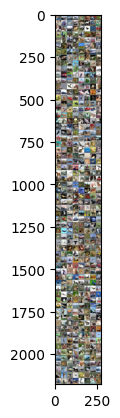

Ground truth: cat  , ship , ship , plane, frog , frog , car  , frog , cat  , car  , plane, truck, dog  , horse, truck, ship , dog  , horse, ship , frog , horse, plane, deer , truck, dog  , bird , deer , plane, truck, frog , frog , dog  , deer , dog  , truck, bird , deer , car  , truck, dog  , deer , frog , dog  , frog , plane, truck, cat  , truck, horse, frog , truck, ship , plane, cat  , ship , ship , horse, horse, deer , frog , horse, cat  , frog , cat  , frog , bird , car  , bird , cat  , horse, bird , frog , ship , ship , plane, bird , truck, cat  , cat  , ship , ship , car  , car  , horse, bird , dog  , bird , horse, ship , truck, plane, cat  , ship , frog , deer , frog , frog , plane, plane, horse, deer , dog  , frog , cat  , car  , car  , cat  , frog , ship , horse, deer , plane, frog , bird , car  , cat  , plane, deer , bird , horse, ship , cat  , car  , bird , ship , plane, ship , cat  , dog  , bird , deer , car  , ship , truck, car  , bird , truck, horse, bird , truck, frog ,

In [14]:
data_iter = iter(test_dl)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images))
print(f"Ground truth: {', '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE))}")

In [15]:
saved_model = create_resnet18_model()
saved_model.load_state_dict(torch.load(model_path))
saved_model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
output = saved_model(images.to(DEVICE))
_, predicted = torch.max(output, 1)

In [17]:
print(f"Predictions: {', '.join(f'{classes[predicted[j]]:5s}' for j in range(BATCH_SIZE))}")

Predictions: cat  , ship , car  , plane, frog , frog , car  , frog , cat  , car  , plane, truck, dog  , horse, truck, ship , dog  , horse, ship , frog , horse, plane, deer , truck, deer , horse, deer , plane, truck, frog , cat  , dog  , deer , bird , truck, ship , horse, truck, truck, dog  , deer , frog , horse, frog , plane, truck, cat  , truck, horse, frog , truck, ship , truck, cat  , ship , ship , horse, horse, horse, frog , horse, dog  , frog , cat  , frog , bird , car  , bird , dog  , horse, bird , cat  , ship , ship , truck, bird , plane, cat  , dog  , ship , ship , car  , car  , horse, bird , horse, bird , cat  , ship , truck, plane, cat  , ship , frog , deer , frog , frog , plane, plane, horse, deer , dog  , frog , cat  , car  , car  , cat  , frog , ship , horse, deer , plane, frog , bird , car  , cat  , plane, deer , horse, horse, ship , horse, car  , bird , ship , bird , ship , cat  , frog , plane, deer , car  , ship , truck, car  , bird , truck, horse, bird , ship , frog , 

In [18]:
correct_pred = {class_name: 0 for class_name in classes}
total = {class_name: 0 for class_name in classes}

saved_model.eval()

with torch.no_grad():
    for data in test_dl:
        images, labels = data

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        output = saved_model(images)

        _, predicted = torch.max(output, 1)
        
        for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total[classes[label]] += 1

for class_name, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total[class_name]
    print(f"Accuracy of {class_name:5s}: {accuracy:.3f}%")

Accuracy of plane: 85.100%
Accuracy of car  : 85.700%
Accuracy of bird : 77.500%
Accuracy of cat  : 55.400%
Accuracy of deer : 80.700%
Accuracy of dog  : 80.300%
Accuracy of frog : 84.800%
Accuracy of horse: 85.900%
Accuracy of ship : 89.900%
Accuracy of truck: 92.300%
